In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

from fgnn.fraud_detector import FraudRGCN

# Load test transactions

In [2]:
df_test = pd.read_parquet('./data/test.parquet')

# Evaluate trained models on full test set and save results

It will take over 1.5 hours to run these evaluations. Note that we load fresh model for every k, and it takes ~75 seconds to load each model. Also, predicting on full test set (call to `fd.predict`) takes ~90-115 seconds. 

In [ ]:
results = []

## evaluate models on full test set
for mode in ['transductive', 'inductive' ]:
    for ii in range(1,6):
        for kk in [1, 2, 3]:
            fd = FraudRGCN.load_fg(f"model/{mode}_{ii}")
            fraud_proba=fd.predict(df_test, k=kk)
            auc=roc_auc_score(df_test.isFraud, fraud_proba)
            elaps=fd._timings['predict: total'][-1]
            print(mode, ii, kk, elaps, auc)
            results.append((mode, ii, kk, elaps, auc))
            
## save results to csv
df_results = pd.DataFrame(results, columns=['mode', 'trial', 'k', 'time', 'AUC'])
df_results.to_csv('full_results.csv', header=True, index=False)

In [27]:
df_results = pd.read_csv('full_results.csv')

# Evaluate inductive models on test set in batches and save results

We split test set into 28 batches of ~1000 transactions each. 

It will take over half hour to complete these evaluations. Note that we load fresh model for every k, and it takes ~75 seconds to load each model. It takes ~3-5 seconds to predict on each batch. 


In [3]:
import torch as th

In [ ]:
batch_results = []

## evaluate inductive models on test set in batches of ~1000 transactions
for mode in ['inductive',]:
    for ii in range(1,6):
        for kk in [1, 2, 3,]:
            fd = FraudRGCN.load_fg(f"model/{mode}_{ii}")
            fraud_proba=[]
            for batch in np.array_split(df_test, 28):
                fraud_proba.append(fd.predict(batch, k=kk))
                
                n_nodes = th.sum(th.tensor([fd._train_g.number_of_nodes(n_type) for n_type in fd._train_g.ntypes]))
                n_lookup = np.sum([len(lookup) for ntype, lookup in fd._nodes_lookup.items()])
                
                n_edges = th.sum(th.tensor([fd._train_g.number_of_edges(e_type) for e_type in fd._train_g.etypes]))

                print("""----After Inference Internal Storage------'
                            #Nodes: {}
                            #Edges: {}
                            #Lookup keys: {}
                            """.format(n_nodes,n_edges, n_lookup))

            fraud_proba=np.concatenate(fraud_proba)
            
            auc=roc_auc_score(df_test.isFraud, fraud_proba)
            elaps=np.mean(fd._timings['predict: total'])
            
            print(mode, ii, kk, elaps, auc)
            batch_results.append((mode, ii, kk, elaps, auc))
            
## save results to csv
df_batch_results = pd.DataFrame(batch_results, columns=['mode', 'trial', 'k', 'time', 'AUC'])
df_batch_results.to_csv('batch_results.csv', header=True, index=False)

In [19]:
# df_batch_results= pd.read_csv('batch_results.csv')

# Compute averages over five trials

In [29]:
df_results.groupby(by=['mode', 'k'], as_index=False).mean().drop(columns=['trial'])

,mode,k,time,AUC
0,inductive,1,114.949820,0.865619
1,inductive,2,115.620539,0.876345
2,inductive,3,116.139071,0.876345
3,transductive,1,144.551463,0.874942
4,transductive,2,145.125455,0.882842
5,transductive,3,145.168193,0.882842


In [30]:
df_batch_results.groupby(by=['mode', 'k'], as_index=False).mean().drop(columns=['trial'])

,mode,k,time,AUC
0,inductive,1,4.739232,0.849324
1,inductive,2,5.443790,0.876169
2,inductive,3,6.169718,0.876169


# Plot model performance for inductive vs transductive modes

In [65]:
%pip install -q seaborn

Note: you may need to restart the kernel to use updated packages.


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
sns.set(font_scale=2)

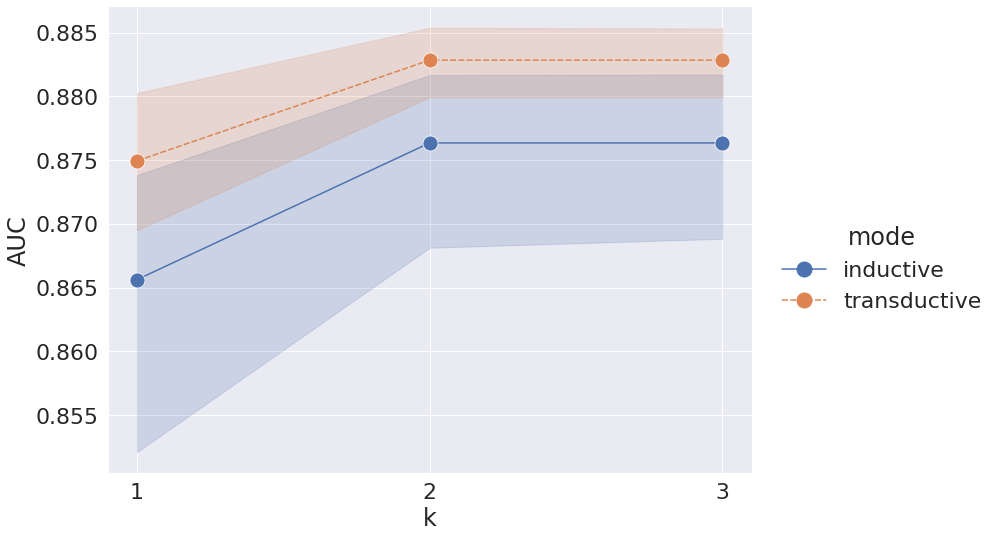

In [24]:
g=sns.relplot(
    data=df_results.query("k < 4"), x="k", y="AUC",  aspect=1.4, height=8, 
    hue="mode", style="mode", kind="line", markers=['o', 'o'], hue_order=['inductive', 'transductive'],style_order=['inductive', 'transductive'],
    markersize=15,
)

for h in g._legend.legendHandles:
    h.set_markersize(15)
    
g.set(xticks= [1, 2, 3])
g.tight_layout()

plt.savefig('inductive_transductive.png')

# Plot model performance when predicting in batches

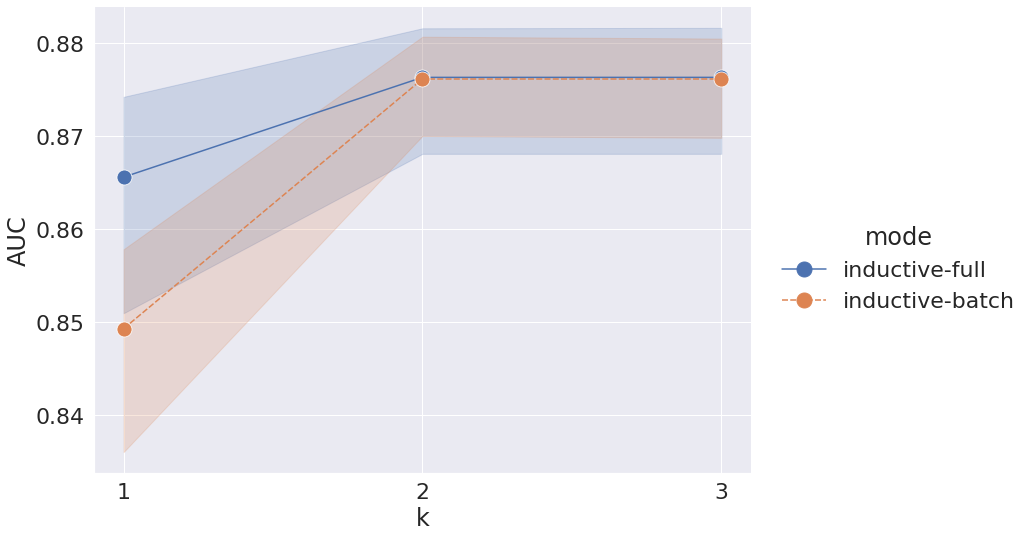

In [25]:
df_batch = pd.concat([
    df_results.query('mode == "inductive"').assign(mode="inductive-full"), 
    df_batch_results.assign(mode="inductive-batch")
], ignore_index=True)

                      
g=sns.relplot(
    data=df_batch, x="k", y="AUC", aspect=1.4, height=8, 
    hue="mode", style="mode", kind="line", markers=['o', 'o'], markersize=15,
)

for h in g._legend.legendHandles:
    h.set_markersize(15)
    
    
g.set(xticks= [1, 2, 3])
g.tight_layout()
plt.savefig('full_batch.png')



# Plot batch prediction latencies

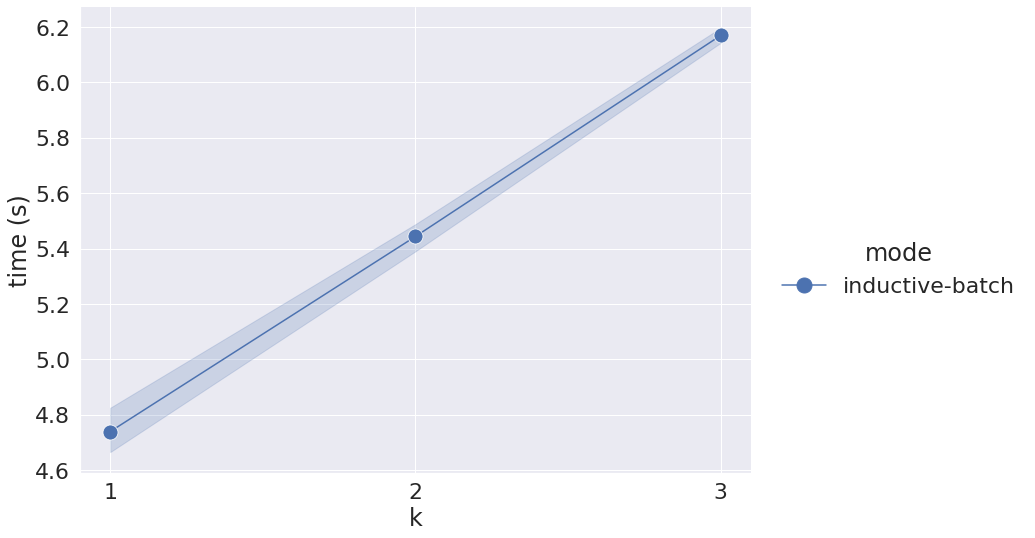

In [26]:
g=sns.relplot(
    data=df_batch_results.assign(mode="inductive-batch").rename(columns={'time':'time (s)'}), x="k", y="time (s)",
    aspect=1.4, height=8, 
    hue="mode", style="mode", kind="line", markers=['o'], markersize=15,
)

for h in g._legend.legendHandles:
    h.set_markersize(15)
    
g.set(xticks= [1, 2, 3])
g.tight_layout()
plt.savefig('timing.png')